SATYAM SRIVASTAVA  
220986  
MAJOR ASSIGNMENT 2  
DEEPFLOW - STAMATICS  
Date - 05/07/2005

#Step 1: Imports and Paths

In [17]:

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

BASE_DIR = "./"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")
LABELS_FILE = os.path.join(BASE_DIR, "labels.csv")
SAMPLE_SUB_FILE = os.path.join(BASE_DIR, "sample_submission.csv")


#Step 2: Load all data 

In [18]:

labels_df = pd.read_csv(LABELS_FILE)

labels_df["id"] = labels_df["id"].astype(str) + ".jpg"
labels_df["label"] = labels_df["breed"].astype("category").cat.codes
class_mapping = dict(enumerate(labels_df["breed"].astype("category").cat.categories))
num_classes = len(class_mapping)


Step 3: Train-Validation Split

In [19]:

train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df["label"],
    random_state=42
)


Step 4: Data Generators

In [20]:
IMG_SIZE = 224
BATCH_SIZE = 32  # increase for faster training if GPU available

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    train_df,
    directory=TRAIN_DIR,
    x_col="id",
    y_col="breed",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    val_df,
    directory=TRAIN_DIR,
    x_col="id",
    y_col="breed",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


Step 5: Model

In [21]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,437,432 (9.30 MB)

 Trainable params: 179,448 (700.97 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Step 6: Train

In [22]:

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)
# Step 6.1: Accuracy Check
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


c:\Users\Satya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 135s 505ms/step - accuracy: 0.3652 - loss: 2.9636 - val_accuracy: 0.7051 - val_loss: 0.9759
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 134s 524ms/step - accuracy: 0.8077 - loss: 0.6608 - val_accuracy: 0.7579 - val_loss: 0.7977
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 121s 473ms/step - accuracy: 0.8796 - loss: 0.4040 - val_accuracy: 0.7550 - val_loss: 0.8335
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 108s 421ms/step - accuracy: 0.9219 - loss: 0.2787 - val_accuracy: 0.7491 - val_loss: 0.7910
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 106s 413ms/step - accuracy: 0.9465 - loss: 0.1987 - val_accuracy: 0.7570 - val_loss: 0.8062
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 105s 408ms/step - accuracy: 0.9683 - loss: 0.1355 - val_accuracy: 0.7653 - val_loss: 0.8058
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 120s 470ms/step - accuracy: 0.9873 - loss: 0.0893 - val_accuracy: 0.7619 - val_loss: 0.8301
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 105s 408ms/step - accuracy: 0.9888 -

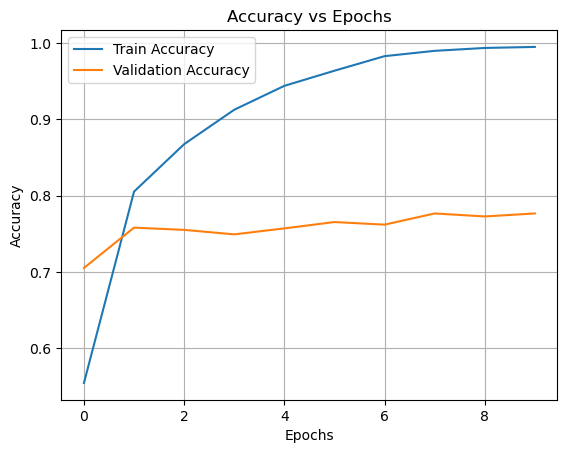

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

Step 7: Predict on test set

In [24]:
sample_sub = pd.read_csv(SAMPLE_SUB_FILE)
sample_sub['id'] = sample_sub['id'].astype(str) + '.jpg'

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    sample_sub,
    directory=TEST_DIR,
    x_col="id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

preds = model.predict(test_gen, verbose=1)

preds_df = pd.DataFrame(preds, columns=class_mapping.values())
preds_df.insert(0, 'id', sample_sub['id'].str.replace('.jpg', '', regex=False))
preds_df.to_csv("submission.csv", index=False)
print("✅ Full submission.csv saved")


Found 10357 validated image filenames.


c:\Users\Satya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10357/10357 ━━━━━━━━━━━━━━━━━━━━ 469s 45ms/step
✅ Full submission.csv saved


Saving Model

In [25]:
model.save("cnn_model_full.h5")
print("✅ Model saved as cnn_model_full.h5")

✅ Model saved as cnn_model_full.h5


THE END